In [1]:
import numpy as np
import pandas as pd

from collab2.foraging.toolkit import (
    dataObject,
    generate_local_windows,
    plot_predictor,
    rescale_to_grid,
    velocity_predictor_contribution,
)

In [2]:
# create a test object with random data
num_frames = 8
num_foragers = 4
grid_size = 30
n_nans = int(num_frames * num_foragers / 5)
n_missing = int(num_frames * num_foragers / 5)
gridMin = -1
gridMax = 1

np.random.seed(42)

# generate data in a unit disk
theta = 2 * np.pi * np.random.rand(num_frames * num_foragers)
r = np.random.rand(num_frames * num_foragers)

data = {
    "x": r * np.cos(theta),
    "y": r * np.sin(theta),
    "time": np.tile(np.arange(num_frames), num_foragers),
    "forager": np.concatenate([i * np.ones(num_frames) for i in range(num_foragers)]),
}

foragersDF = pd.DataFrame(data)

# # add nan values
# nan_ind = np.random.randint(0, num_frames * num_foragers, size=n_nans)
# foragersDF.loc[nan_ind, ["x", "y"]] = np.nan

# # remove values for certain time points
# drop_ind = np.random.randint(0, num_frames * num_foragers, size=n_missing)
# foragersDF = foragersDF.drop(drop_ind)

# scaling and subsampling
foragersDF_scaled = rescale_to_grid(
    foragersDF, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
foragers_object = dataObject(foragersDF_scaled, grid_size=grid_size, frames=num_frames)

In [3]:
# get local windows
local_windows_kwargs = {
    "window_size": 10,
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}

foragers_object.local_windows_kwargs = local_windows_kwargs

local_windows = generate_local_windows(foragers_object)

# Illustration of visualization function
The function takes in any nested list structure (i.e. `local_windows`-like), and plots the value of the column `predictorID` at the specified grid points for a given list of foragers and time frames

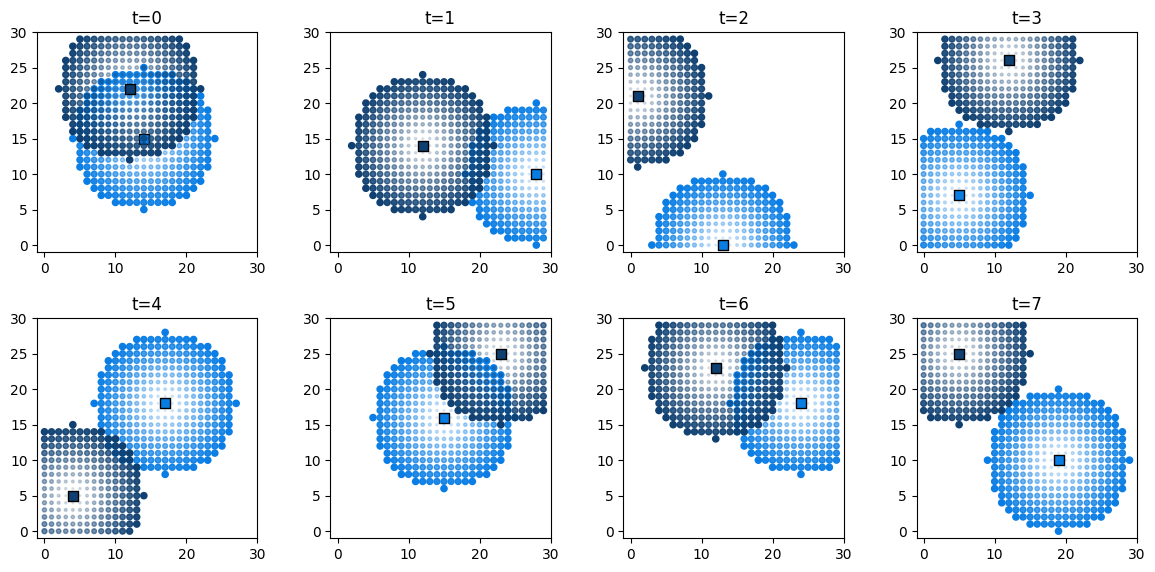

In [4]:
plot_predictor(
    foragers_object.foragers,
    local_windows,
    predictorID="distance_to_f",
    forager_index=[0, 2],
    time=range(num_frames),
    grid_size=grid_size,
    size_multiplier=20,
    random_state=10,  # selects the plot colors
)

# Illustration of velocity predictor calculation
`velocity_predictor_contribution(..)` assigns a predictor score to every grid point given a preferred ($v$, $\theta$), location of focal forager, and chosen gaussian widths

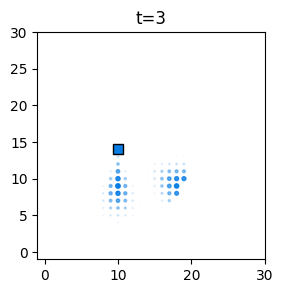

In [8]:
# visualize  velocity_predictor_contribution for a test case
test_pred = [[None for i in range(num_frames)] for j in range(num_foragers)]

# compute the predictor contribution for a random case
f = 3
t = 3
x = foragers_object.foragers[f].loc[t, "x"]
y = foragers_object.foragers[f].loc[t, "y"]
sigma_v = 2
sigma_t = np.pi / 20

v_pref1 = 5
theta_pref1 = -np.pi / 2
v_pred1 = velocity_predictor_contribution(
    v_pref1, theta_pref1, x, y, local_windows[f][t], sigma_v, sigma_t
)

v_pref2 = 10
theta_pref2 = -np.pi / 6
v_pred2 = velocity_predictor_contribution(
    v_pref2, theta_pref2, x, y, local_windows[f][t], sigma_v, sigma_t
)

# additive combination
test_pred[f][t] = local_windows[f][t].copy()
test_pred[f][t]["v_pred"] = (v_pred1 + v_pred2) / 2


plot_predictor(
    foragers_object.foragers,
    test_pred,
    "v_pred",
    [f],
    [t],
    grid_size,
    size_multiplier=10,
    random_state=10,
)